# Telco Customer Churn Project

## Imports

In [81]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Classification Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Dataset import
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")



## Exploratory Data Analysis (EDA)

In [82]:
# Basic info about the dataset
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()


The dataset contains 7043 rows and 21 columns.


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [83]:
# Data Types and Missing Values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Problem:** TotalCharges is a object while it should be a numerical value (float, just like MonthlyCharges. This can indicate missing values (empty strings).

In [84]:
# Searching for empty strings in TotalCharges
(df['TotalCharges'].str.strip() == '').sum()



np.int64(11)

In [85]:
df[df['TotalCharges'].str.strip() == ''][['customerID', 'TotalCharges', 'tenure']]


customerID TotalCharges  tenure
488   4472-LVYGI                    0
753   3115-CZMZD                    0
936   5709-LVOEQ                    0
1082  4367-NUYAO                    0
1340  1371-DWPAZ                    0
3331  7644-OMVMY                    0
3826  3213-VVOLG                    0
4380  2520-SGTTA                    0
5218  2923-ARZLG                    0
6670  4075-WKNIU                    0
6754  2775-SEFEE                    0

**Explanation**: We found 11 entries with empty strings, which correspond to customers with `tenure == 0`, meaning they are newly joined and have not been charged yet.


In [86]:
## Correcting the empty strngs
# Convert TotalCharges to float, coercing invalid values to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing charges with 0 (reasonable, as tenure = 0)
df['TotalCharges'].fillna(0, inplace=True)




<ipython-input-86-88863815bfc3>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [87]:
# Descriptive statistics
df.describe()


SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    7043.000000  7043.000000     7043.000000   7043.000000
mean        0.162147    32.371149       64.761692   2279.734304
std         0.368612    24.559481       30.090047   2266.794470
min         0.000000     0.000000       18.250000      0.000000
25%         0.000000     9.000000       35.500000    398.550000
50%         0.000000    29.000000       70.350000   1394.550000
75%         0.000000    55.000000       89.850000   3786.600000
max         1.000000    72.000000      118.750000   8684.800000

In [88]:
# Unique Values per Column
df.nunique()

for col in df.columns:
    if df[col].dtype == 'object':
        print(f"\n{col}: {df[col].unique()}")



customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender: ['Female' 'Male']

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['Yes' 'No' 'No internet service']

DeviceProtection: ['No' 'Yes' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['No' 'Yes' 'No internet service']

StreamingMovies: ['No' 'Yes' 'No internet service']

Contract: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

Churn: ['No' 'Yes']


In [89]:
# Checking for Negative Values

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    if (df[col] < 0).any():
        print(f"Warning: Negative values found in {col}")


Churn
No     5174
Yes    1869
Name: count, dtype: int64
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


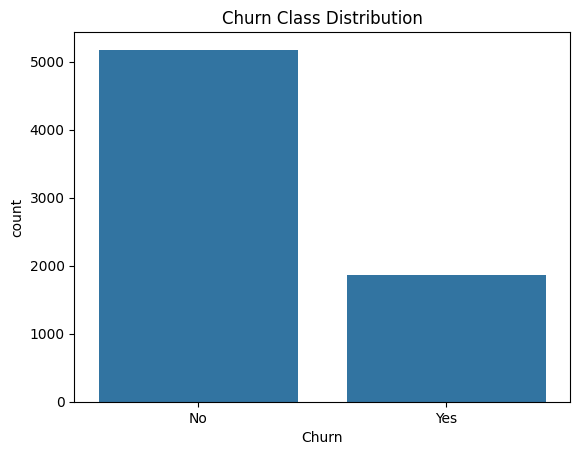

In [90]:
# Target Class (Churn) Distribution
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Churn')
plt.title("Churn Class Distribution")
plt.show()


**Problem**: The target variable `Churn` is highly imbalanced. Approximately 73% of the customers did not churn, while only about 27% did. This imbalance can negatively impact the performance of classification models, as they may become biased toward predicting the majority class (no churn).


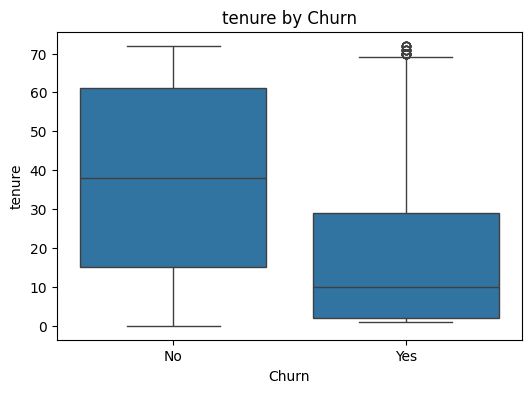

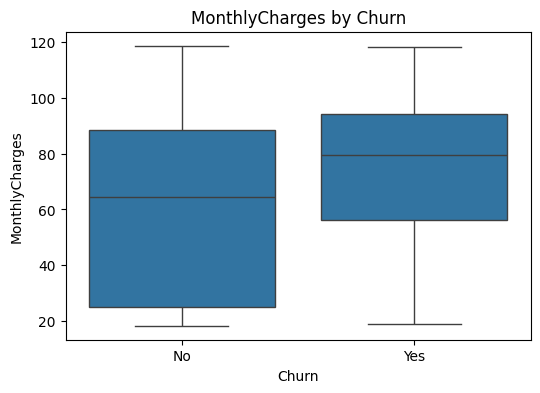

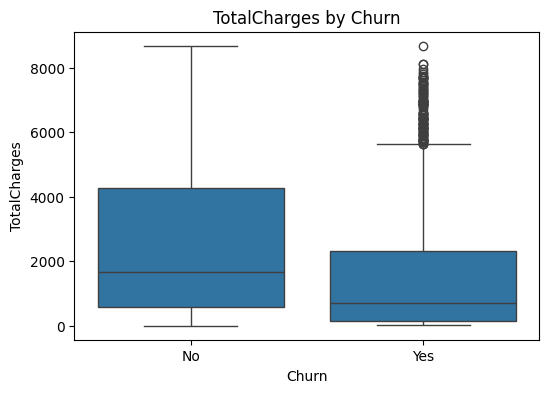

In [91]:
# Box plots (numerical values x churn)
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} by Churn')
    plt.show()


**Insight**: Customers who churn tend to have:
- Lower `tenure` (i.e., they are newer customers) - but there are some outliers,
- Higher `MonthlyCharges`,
- Lower `TotalCharges` (due to short tenure).
This suggests that many customers who leave are new and already paying high amounts. There are outliers.


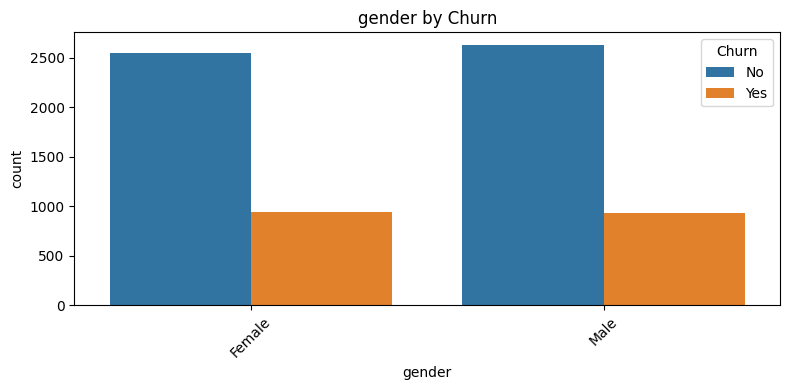

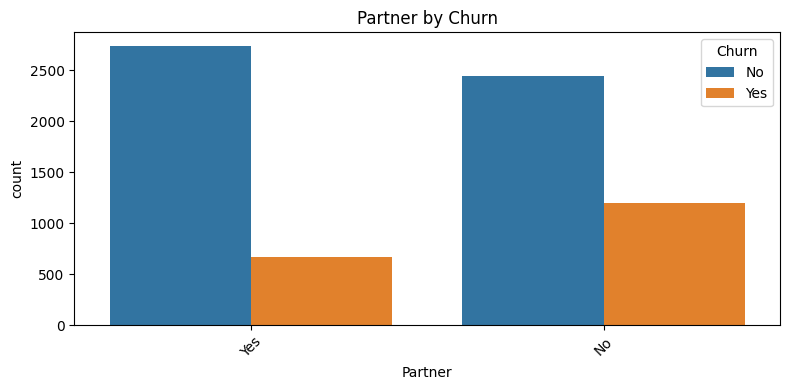

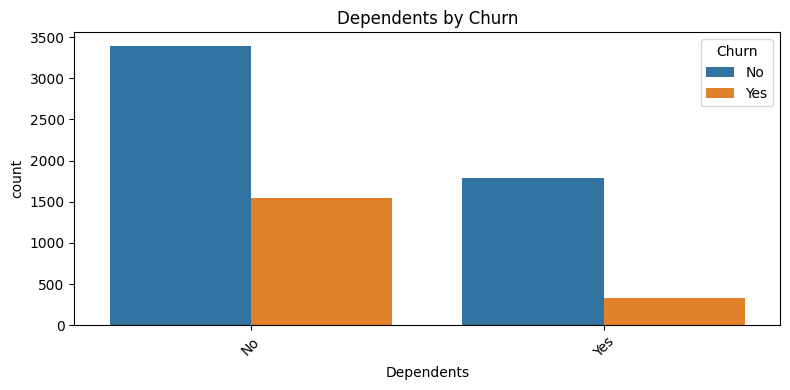

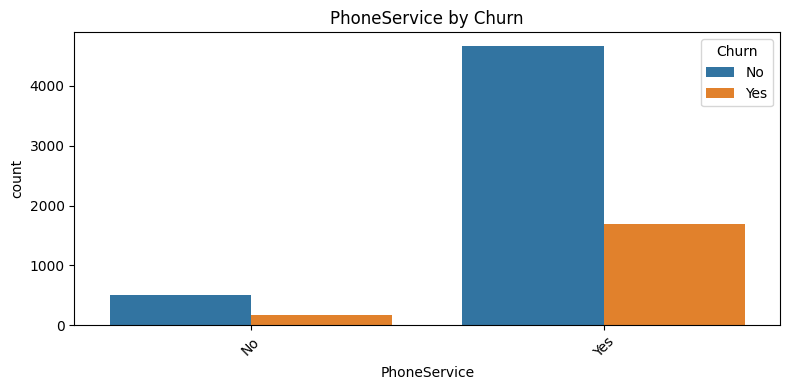

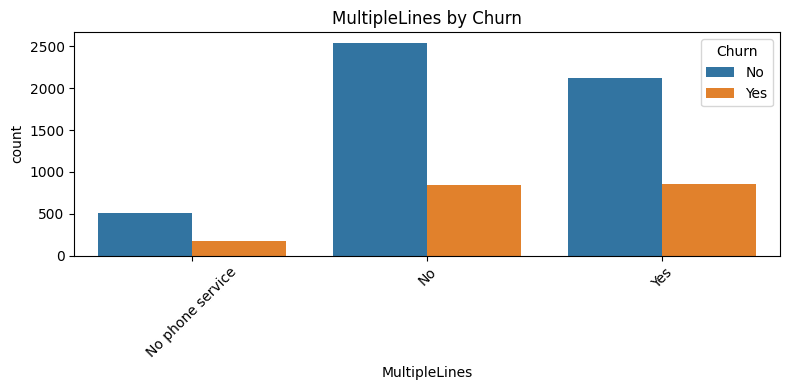

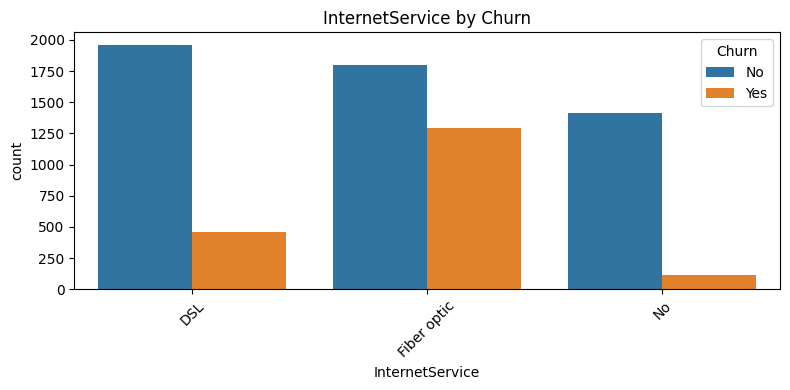

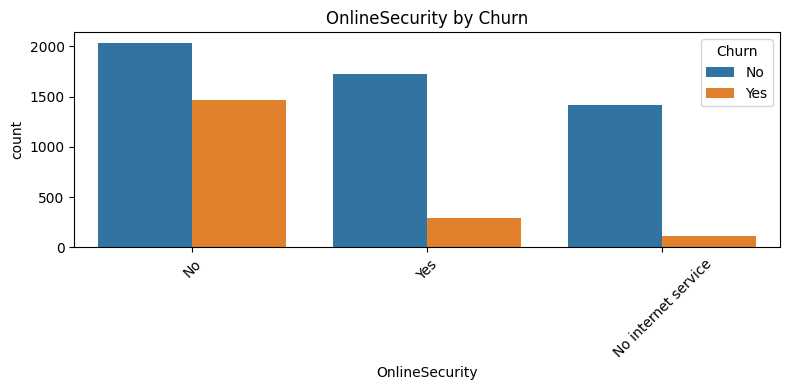

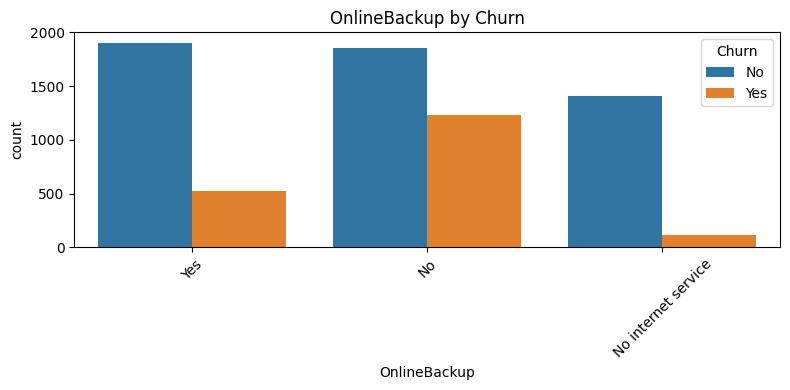

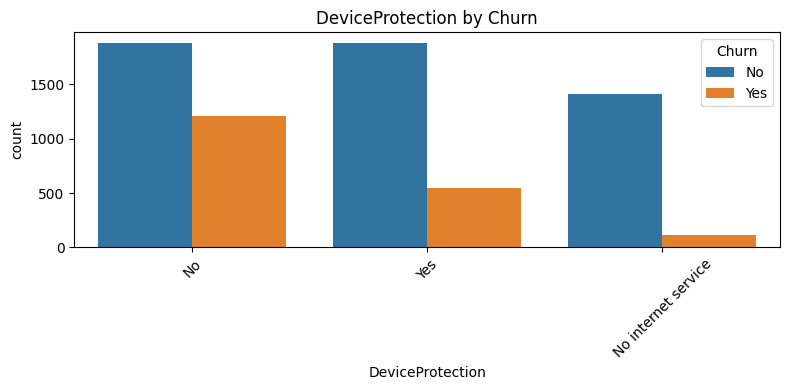

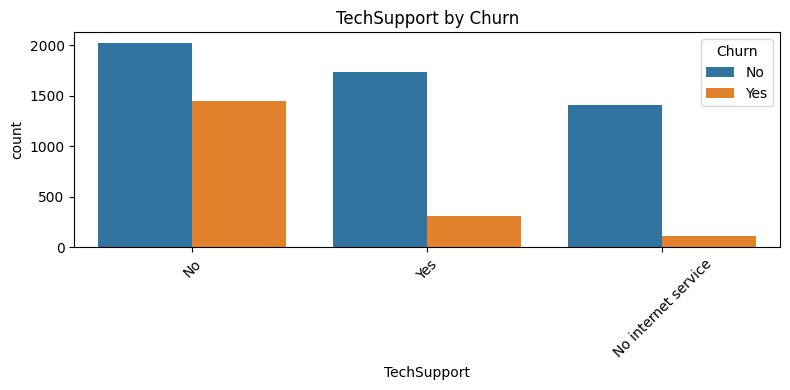

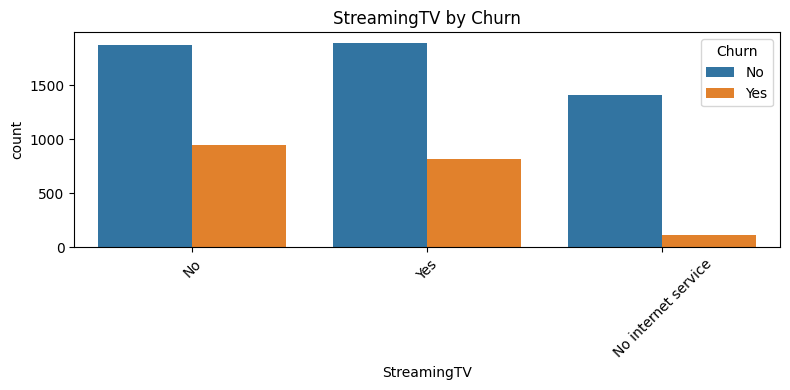

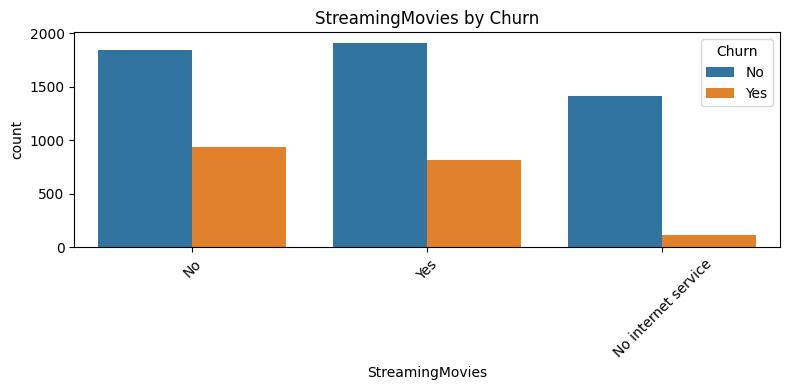

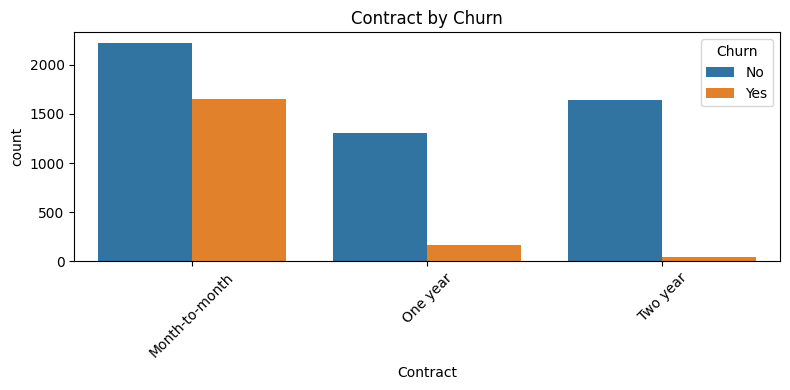

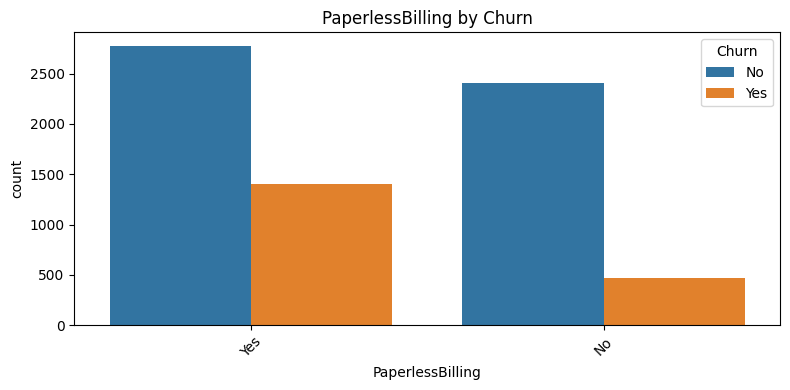

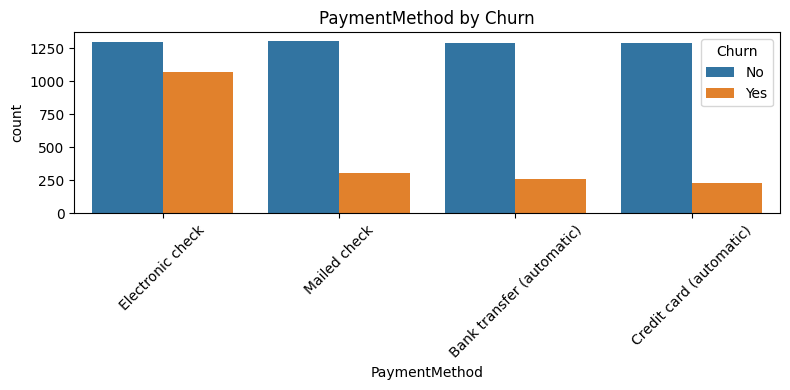

In [92]:
# Categorical attributes x churn
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('customerID')
cat_cols.remove('Churn')

for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} by Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


**Insight**: Churn is more common among:
- Customers with month-to-month contracts,
- Customers with no dependents,
- Those who use electronic checks as payment method,
- Customers with fiber optic internet,
- Those without additional services like OnlineSecurity or TechSupport.

These patterns suggest that lack of service bundling and flexibility in payment/contract increase the chance of churn.


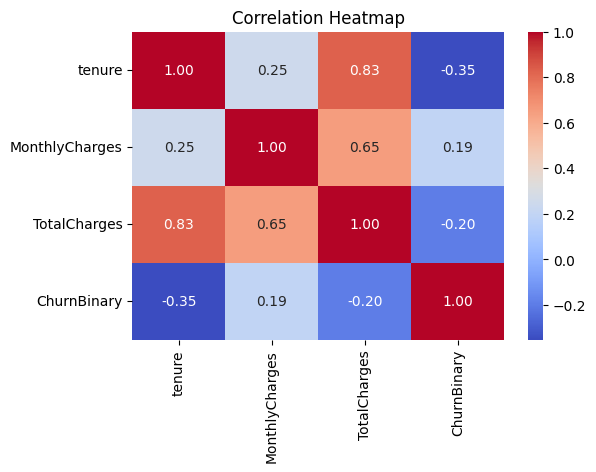

In [93]:
## Correlation Heatmap (numeric features + churn)
df['ChurnBinary'] = df['Churn'].map({'No': 0, 'Yes': 1})

corr_matrix = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnBinary']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


**Insight**:
- `Churn` is negatively correlated with `tenure` (strongest),
- Slight positive correlation with `MonthlyCharges`,
- Moderate negative correlation with `TotalCharges`.

This confirms our earlier observation that short-tenure, high-monthly-fee customers are more likely to churn.


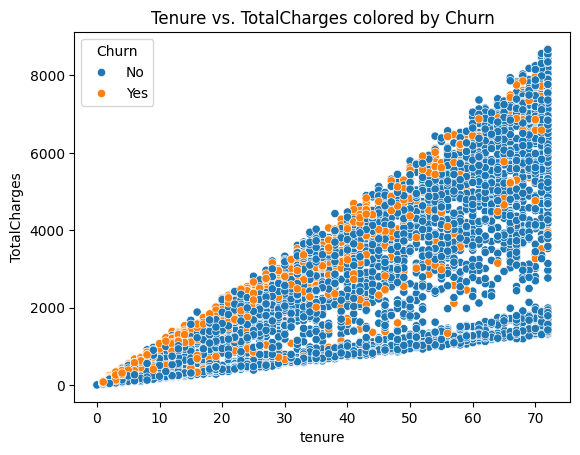

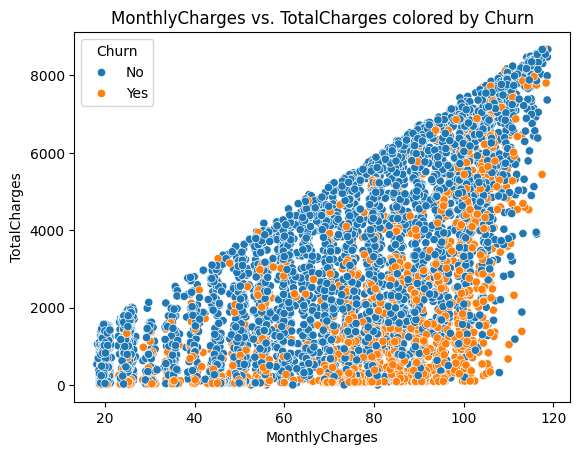

In [94]:
# Scatterplots between numerical attributes
sns.scatterplot(data=df, x='tenure', y='TotalCharges', hue='Churn')
plt.title("Tenure vs. TotalCharges colored by Churn")
plt.show()

sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn')
plt.title("MonthlyCharges vs. TotalCharges colored by Churn")
plt.show()


**Insight**:
- Customers who churn cluster in regions of low tenure and low-to-mid TotalCharges.
- There's a high-density cluster of non-churners with high TotalCharges and tenure.


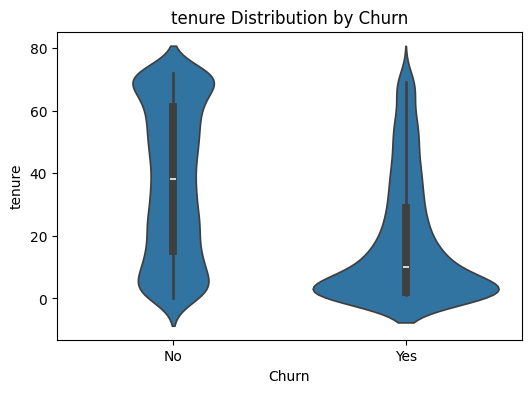

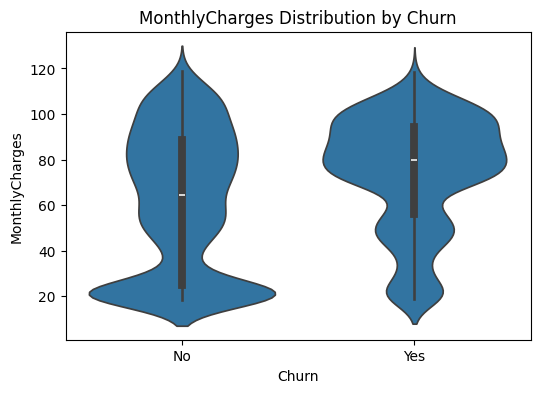

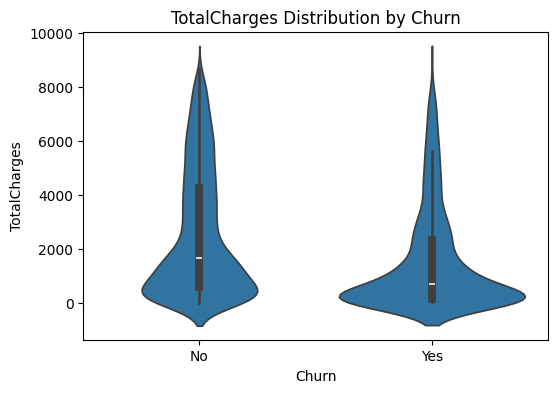

In [95]:
## Violin plots
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.violinplot(x='Churn', y=col, data=df)
    plt.title(f'{col} Distribution by Churn')
    plt.show()


**Insight**:
- Violin plots show clear distribution differences:
  - `tenure`: churners mostly between 0–20 months.
  - `MonthlyCharges`: churners have bimodal distribution with peaks in low and high values.


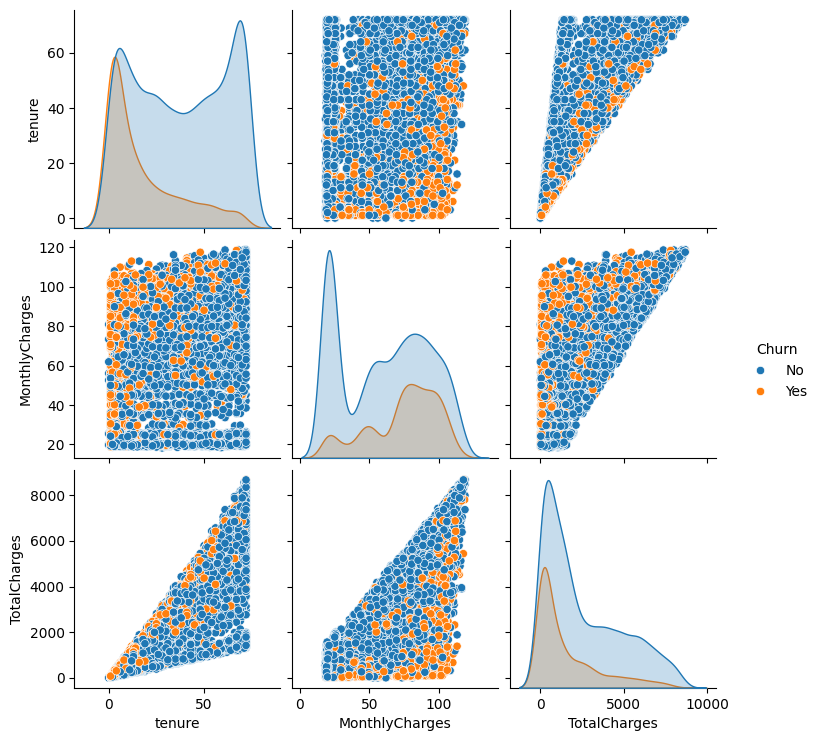

In [96]:
# Pairplots
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')


### EDA Summary and Key Insights

After a thorough exploratory data analysis of the Telco Customer Churn dataset, several important insights emerged:

1. **Class Imbalance**  
   The target variable `Churn` is imbalanced: approximately 73% of customers did not churn, while 27% did. This imbalance indicates that accuracy alone is not a sufficient evaluation metric — we must rely on precision, recall, F1-score, and ROC-AUC.

2. **Numerical Variables**  
   - **Tenure**: Customers who churn tend to have very short tenure — many have been customers for fewer than 20 months.
   - **MonthlyCharges**: Churners often pay higher monthly fees.
   - **TotalCharges**: Churners typically have lower total charges due to their short tenure.

3. **Categorical Variables**  
   - Churn is more prevalent among customers with **month-to-month contracts**, those using **electronic checks**, and those with **fiber optic internet**.
   - Customers **without additional services** (e.g., OnlineSecurity, TechSupport, OnlineBackup) are more likely to churn, suggesting that bundled services improve retention.

4. **Correlations**  
   - `Churn` has a strong **negative correlation with tenure**, and a slight **positive correlation with MonthlyCharges**.
   - Customers with **long tenure and high total charges** are highly unlikely to churn.

5. **Visual Patterns**  
   - Scatter and violin plots reinforce that churned customers tend to concentrate in a low-tenure, high-monthly-charge region.
   - Several categorical variables show **visibly different distributions** when segmented by churn, highlighting their predictive potential.

These insights will guide our **feature selection**, **preprocessing**, and **modeling strategies**, particularly in addressing class imbalance and focusing on high-risk customer profiles.


## Pre - Processing

In [97]:
# Eliminating useless attributes for prediction
df.drop(['customerID'], axis=1, inplace=True)


In [98]:
# Converting categoric attributes to numerical, necessary for the classifier models
# Binary mapping
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Handle "gender" as well
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encode remaining categoricals
df = pd.get_dummies(df, drop_first=True)


In [99]:
# Splitting data between training and test
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Stratified split to preserve churn distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Check proportions to confirm stratification worked
print("Train Churn Rate:", y_train.mean())
print("Test Churn Rate:", y_test.mean())


Train Churn Rate: 0.2653532126375577
Test Churn Rate: 0.2654364797728886


In [100]:
# Attribute standardization, essencial for models based on distances
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [101]:
## Balancing class and oversampling, since our dataset is highly unbalanced between churn and no churn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

# Apply only on the train set
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Verifying
from collections import Counter
print("Original training set:", Counter(y_train))
print("Resampled training set:", Counter(y_train_resampled))


Original training set: Counter({0: 4139, 1: 1495})
Resampled training set: Counter({0: 4139, 1: 4139})


### Preprocessing Summary

- Removed the non-informative `customerID` column.
- Converted binary categorical features (e.g., `Partner`, `Churn`) to numerical using label mapping.
- Applied one-hot encoding to multi-category variables.
- Split the dataset into training and test sets using stratified sampling to preserve class distribution.
- Standardized numerical features using `StandardScaler` to ensure equal scale across variables.
- Balanced the training set using SMOTE to address class imbalance (~26.5% churn rate).

### ⚠️ Note on Manual Preprocessing

In the preprocessing phase, we manually applied `StandardScaler` and `SMOTE` to better understand how each technique works in isolation:

- **StandardScaler** was used to normalize numerical attributes, essential for distance-based algorithms.
- **SMOTE** (Synthetic Minority Over-sampling Technique) was applied to balance the training set due to the significant class imbalance in the target variable.

These steps were helpful for exploration and debugging, but **they are not used in the final model training**, since it would cause data leakage (e.g, synthetic data contaiminating the test set).

## Applying the Machine Learning Classifier Algorithms

### Decision Tree

A Decision Tree builds a flowchart-like structure that recursively splits (divide and conquer paradigm) the dataset based on feature values to create regions that are as pure as possible (mostly one class).

- At each node, it selects the feature that best separates the data using criteria like **Gini Impurity** or **Entropy**.
- The tree grows by splitting the data until a stopping condition is met (e.g., max depth or pure leaves).
- During prediction, the model follows the path down the tree according to the feature values of the input, ending in a leaf node that determines the class.

Decision Trees are highly interpretable and well-suited for tabular data but may overfit without pruning.

In [121]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Reload original dataframe
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)

# Drop ID column
df.drop(['customerID'], axis=1, inplace=True)

# Binary encoding
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# One-hot encode
df = pd.get_dummies(df, drop_first=True)

# Define X and y
X = df.drop('Churn', axis=1)
y = df['Churn']

# Final, clean train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline with SMOTE, Scaler, and Decision Tree
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

dt_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(dt_pipeline, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-validated F1-score (Decision Tree): {cv_scores.mean():.4f}")



<ipython-input-121-9835886d5faa>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Cross-validated F1-score (Decision Tree): 0.5892


In [122]:
# Fit and predict
dt_pipeline.fit(X_train, y_train)
y_pred = dt_pipeline.predict(X_test)
y_proba = dt_pipeline.predict_proba(X_test)[:, 1]

Classification Report – Decision Tree:
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      1035
           1       0.48      0.73      0.58       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409



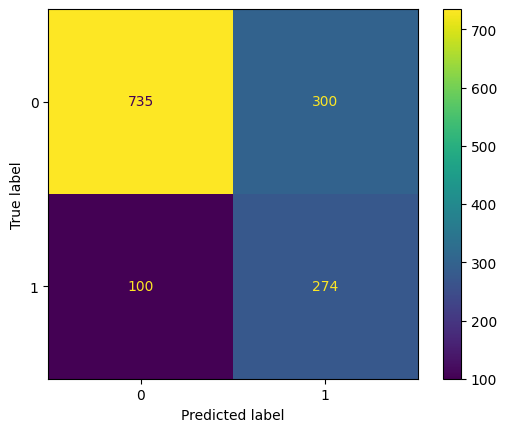

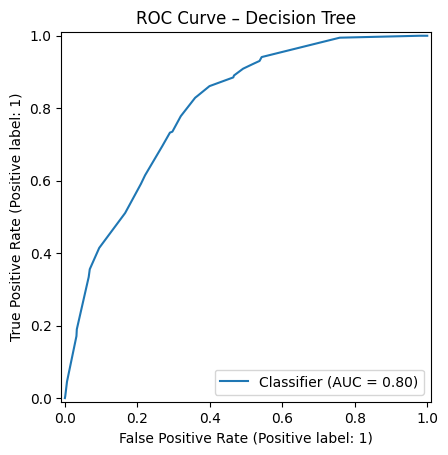

AUC Score: 0.7991526518380738


In [123]:
# Metrics
print("Classification Report – Decision Tree:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – Decision Tree")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba))

####  Decision Tree – Performance Analysis

The Decision Tree model achieved an overall **accuracy of 72%** on the test set.

Key insights:

- **Precision for class 1 (churn)** was **0.48**, meaning that around half of the customers predicted to churn actually did.
- **Recall for churn** was **0.73**, indicating that the model correctly identified 73% of the actual churners.
- The **F1-score for churn** (which balances precision and recall) was **0.58**, which is acceptable given the class imbalance and model simplicity.
- The model performed **better at identifying non-churners (class 0)**, with precision of 0.88, but **struggled more with churners**, which is typical for imbalanced datasets.


### K-Nearest Neighbors (KNN)

K-Nearest Neighbors is a **non-parametric**, instance-based learning algorithm.

- To make a prediction, KNN looks at the **`k` closest training samples** (neighbors) based on distance (usually Euclidean).
- The predicted class is determined by **majority vote** among those neighbors.
- KNN does not "train" a model; instead, it **stores the training data** and makes predictions only when queried.

KNN is intuitive and effective for small to medium datasets, but its performance can degrade with high-dimensional or imbalanced data, and it is sensitive to feature scaling.

In [107]:
# Imports
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Reload the original clean dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, drop_first=True)

# Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: SMOTE + Scaler + KNN
knn_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Cross-validation (f1-score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-validated F1-score (KNN): {cv_scores.mean():.4f}")

# Fit final model
knn_pipeline.fit(X_train, y_train)




<ipython-input-107-313e817b1eed>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Cross-validated F1-score (KNN): 0.5672


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

Classification Report – KNN:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1035
           1       0.46      0.61      0.52       374

    accuracy                           0.70      1409
   macro avg       0.65      0.67      0.65      1409
weighted avg       0.74      0.70      0.71      1409



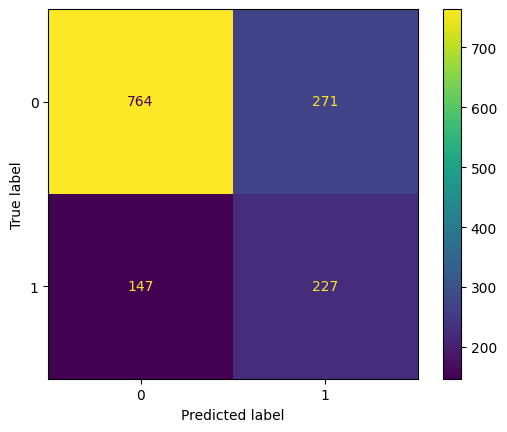

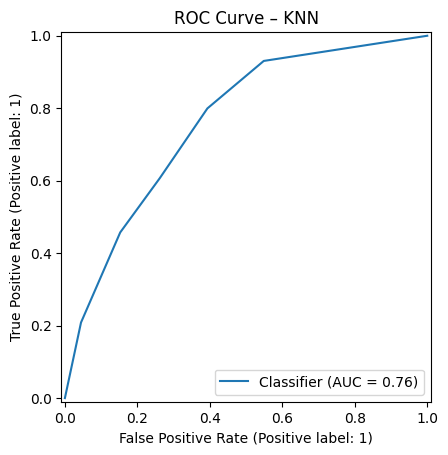

AUC Score: 0.7612273631455218


In [108]:
# Predict on test set
y_pred_knn = knn_pipeline.predict(X_test)
y_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report – KNN:")
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title("ROC Curve – KNN")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba_knn))

#### KNN - Performance Analysis
The K-Nearest Neighbors (KNN) classifier achieved an overall **accuracy of 70%** on the test set.

Key insights:

- **Precision for churners (class 1)** was **0.46**, meaning that less than half of the customers predicted to churn actually did.
- **Recall for churn** was **0.61**, which means the model correctly identified 61% of the actual churners.
- The **F1-score for churn** was **0.52**, slightly lower than the Decision Tree baseline.

The model also showed:
- **Stronger performance in identifying non-churners (class 0)**, with an F1-score of 0.79.
- A tendency to misclassify churners as non-churners, visible from the confusion matrix.

### Naïve Bayes

Naive Bayes is a **probabilistic classifier** based on **Bayes' Theorem** with the **“naive” assumption** that features are conditionally independent given the class.

- It calculates the **probability of each class** given the input features.
- For numerical data, the **Gaussian Naive Bayes** variant assumes that each feature follows a normal (Gaussian) distribution.
- The model predicts the class with the **highest posterior probability**.

Naive Bayes is extremely fast and works well with high-dimensional data, but its strong independence assumption may reduce performance when features are correlated.

In [109]:
# Imports
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Reload original clean dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, drop_first=True)

# Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: SMOTE + Scaler + GaussianNB
nb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', GaussianNB())
])

# Cross-validation (f1-score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_pipeline, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-validated F1-score (Naive Bayes): {cv_scores.mean():.4f}")

# Fit final model
nb_pipeline.fit(X_train, y_train)





<ipython-input-109-b27beb1c8471>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Cross-validated F1-score (Naive Bayes): 0.5710


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('classifier', GaussianNB())])

In [110]:
# Predict on test set
y_pred_nb = nb_pipeline.predict(X_test)
y_proba_nb = nb_pipeline.predict_proba(X_test)[:, 1]

Classification Report – Naive Bayes:
              precision    recall  f1-score   support

           0       0.92      0.57      0.70      1035
           1       0.42      0.86      0.56       374

    accuracy                           0.65      1409
   macro avg       0.67      0.72      0.63      1409
weighted avg       0.79      0.65      0.67      1409



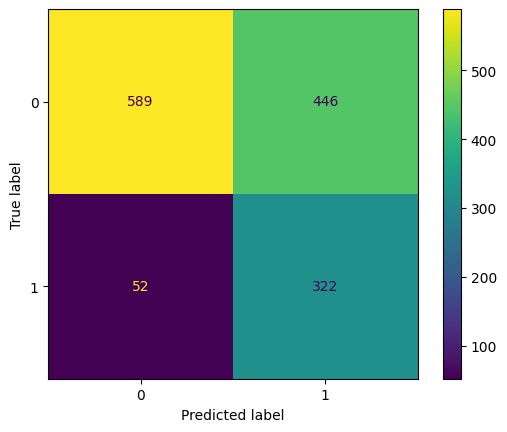

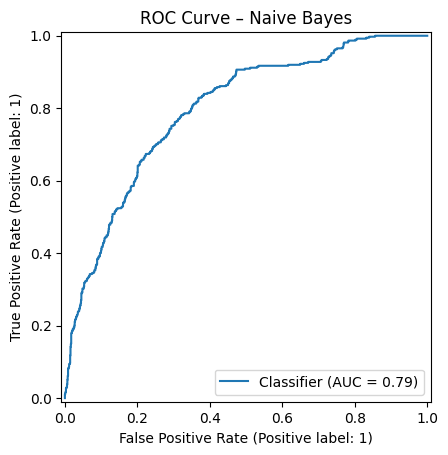

AUC Score: 0.7949184944069855


In [111]:
# Evaluation
print("Classification Report – Naive Bayes:")
print(classification_report(y_test, y_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb)
RocCurveDisplay.from_predictions(y_test, y_proba_nb)
plt.title("ROC Curve – Naive Bayes")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba_nb))

####  Naive Bayes – Performance Analysis

The Naive Bayes classifier achieved an overall **accuracy of 65%** on the test set.

Key insights:

- The model had a **very high recall for churners (class 1)**: **86%**, meaning it correctly identified the majority of actual churn cases.
- However, the **precision for churn** was low (**42%**), indicating a high rate of false positives (many customers predicted to churn actually stayed).
- For non-churners (class 0), the model had **high precision (92%)** but low recall (57%), missing many who didn't churn.


### Support Vector Machine (SVM)

Support Vector Machine (SVM) is a **supervised learning algorithm** used for classification and regression tasks.

- It aims to find the **optimal hyperplane** that best separates the classes in the feature space.
- The **support vectors** are the data points closest to the decision boundary — they are the most critical elements in defining the separation.
- SVM can handle **non-linearly separable data** by using **kernel functions** (e.g., RBF, polynomial) to project the data into higher-dimensional space - this is called "Kernel Trick" technique.
- The `class_weight='balanced'` option helps when dealing with imbalanced datasets.

SVM is powerful for high-dimensional spaces and effective in cases where clear margins of separation exist, but it can be computationally expensive on large datasets.

In [112]:
# Imports
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Reload original clean dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, drop_first=True)

# Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: SMOTE + Scaler + SVM
svm_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
])

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-validated F1-score (SVM): {cv_scores.mean():.4f}")

# Fit final model
svm_pipeline.fit(X_train, y_train)



<ipython-input-112-24ad7774f8d9>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Cross-validated F1-score (SVM): 0.6123


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [113]:
# Predict on test set
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

Classification Report – SVM:
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.64      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.71      1409
weighted avg       0.78      0.77      0.77      1409



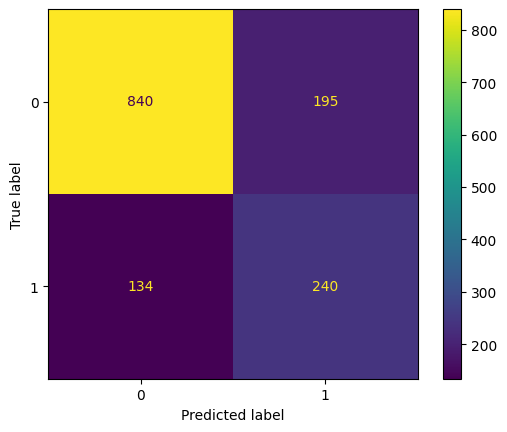

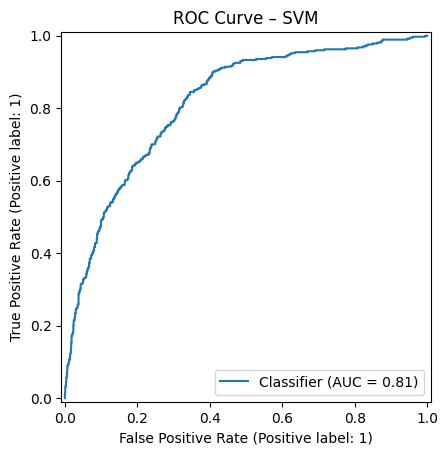

AUC Score: 0.8148789687152859


In [114]:

# Evaluation
print("Classification Report – SVM:")
print(classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
RocCurveDisplay.from_predictions(y_test, y_proba_svm)
plt.title("ROC Curve – SVM")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba_svm))

#### Support Vector Machine (SVM) – Performance Analysis

The SVM classifier achieved an overall **accuracy of 77%** on the test set.

Key insights:

- The model performed **well on both classes**, striking a balance between precision and recall.
- For churners (class 1), it reached a reasonable **recall** of **64%**, meaning it correctly identified most of the customers who actually churned.
- The **precision** for churn was lower than for non-churn, but still acceptable, leading to a **solid F1-score**.
- The confusion matrix shows the model tends to misclassify some churners as non-churners (false negatives), but performs significantly better than simpler models like KNN and Naive Bayes.


### Multi-Layer Perceptron (MLP)

A Multi-Layer Perceptron (MLP) is a type of **feedforward artificial neural network** used for supervised learning tasks.

- It consists of an **input layer**, one or more **hidden layers**, and an **output layer**.
- Each neuron in a layer is connected to all neurons in the next layer, and each connection has a **weight** that is adjusted during training.
- MLP uses **activation functions** (e.g., ReLU, sigmoid) to introduce non-linearity and **backpropagation** to minimize a loss function (usually via gradient descent).
- During training, the model learns patterns in the data by adjusting weights to reduce the prediction error.

MLPs are powerful for capturing complex patterns and interactions between features. However, they require careful tuning and are more sensitive to overfitting and scaling than simpler models.


In [115]:
# Imports
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Dataset reload and preparation
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(0, inplace=True)
df.drop(['customerID'], axis=1, inplace=True)
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, drop_first=True)

# Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Pipeline: SMOTE + Scaler + MLP
mlp_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42))
])

# Cross-validation (F1-score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp_pipeline, X_train, y_train, cv=cv, scoring='f1')
print(f"Cross-validated F1-score (MLP): {cv_scores.mean():.4f}")

# Fit final model
mlp_pipeline.fit(X_train, y_train)




<ipython-input-115-5e8b674777a0>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

Cross-validated F1-score (MLP): 0.5558


Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('classifier', MLPClassifier(max_iter=300, random_state=42))])

In [116]:

# Predict on test set
y_pred_mlp = mlp_pipeline.predict(X_test)
y_proba_mlp = mlp_pipeline.predict_proba(X_test)[:, 1]

Classification Report – MLP:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



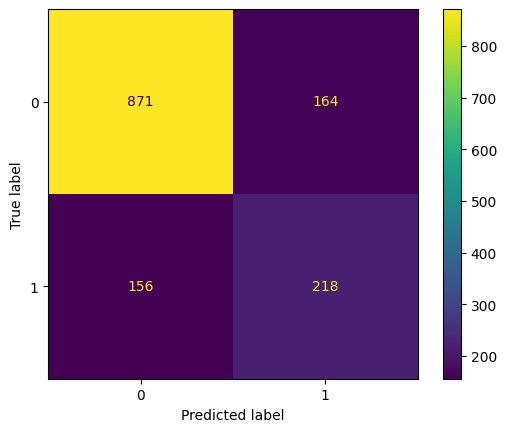

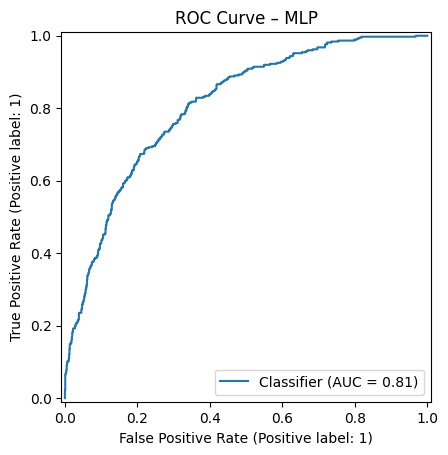

AUC Score: 0.8059727711901624


In [117]:

# Evaluation
print("Classification Report – MLP:")
print(classification_report(y_test, y_pred_mlp))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp)
RocCurveDisplay.from_predictions(y_test, y_proba_mlp)
plt.title("ROC Curve – MLP")
plt.show()
print("AUC Score:", roc_auc_score(y_test, y_proba_mlp))

###  Multi-Layer Perceptron (MLP) – Performance Analysis

The MLP classifier achieved an overall **accuracy of 77%** on the test set.

Key insights:

- The model showed **balanced performance** between the two classes.
- For churners (class 1), the model correctly predicted **218 out of 374 cases**, yielding a **moderate recall**.
- However, **156 churners were misclassified as non-churners**, indicating room for improvement in minimizing false negatives.
- For non-churners (class 0), the model was more reliable, with **871 correct predictions** and fewer false positives than simpler models like Naive Bayes or KNN.

The MLP performed comparably to SVM in terms of accuracy and F1-score, but being a neural network, it has the potential to learn more complex relationships with further tuning (e.g., hidden layers, neurons, activation functions, or dropout). Still, it requires more training time and careful parameter control to avoid overfitting.


## Models Comparison and Summary

After applying and evaluating five different classification algorithms on the Telco Customer Churn dataset, the table below summarizes the key performance metrics for each model:

| Model           | CV F1  | Accuracy | Precision (Churn) | Recall (Churn) | F1-score (Churn) | AUC    |
|----------------|--------|----------|-------------------|----------------|------------------|--------|
| Decision Tree  | 0.5892 | 0.72     | 0.48              | 0.73           | 0.58             | 0.7992 |
| KNN            | 0.5672 | 0.70     | 0.46              | 0.61           | 0.52             | 0.7612 |
| Naive Bayes    | 0.5710 | 0.65     | 0.42              | **0.86**       | 0.56             | 0.7949 |
| SVM            | **0.6123** | **0.77** | 0.55              | 0.64           | 0.59             | **0.8149** |
| MLP            | 0.5558 | **0.77** | **0.57**          | 0.58           | 0.58             | 0.8060 |

###  Key Insights:

- **SVM and MLP** achieved the **highest test accuracy (77%)** and strong AUC values, indicating balanced and reliable performance.
- **SVM** also had the **highest cross-validated F1-score (0.6123)**, reinforcing its consistency across folds.
- **Naive Bayes** stood out with the **highest recall for churners (86%)**, which is valuable when false negatives (missed churn) are critical.
- **Decision Tree** had a strong recall (73%) and competitive AUC, with the advantage of interpretability.
- **KNN** performed adequately but was outperformed in most metrics by the other models.

###  Final Recommendation:

- If your goal is to **maximize recall of churners**, prioritize **Naive Bayes** or **Decision Tree**.
- If you want a **balanced, robust model** with good generalization: go with **SVM**.
- For capturing **non-linear patterns** with flexibility: **MLP** is a strong candidate, especially after tuning.


